Data is provided as csv files, one row for each pixel. This script turns that data into an image format, one image for each city, NaN-padded to be rectangular. Each column of the input csv file becomes a channel of the image, except the spatial lag cols (which are removed).

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [3]:
# Notebook options.
pd.set_option('display.max_rows', 100)
pd.set_option('mode.chained_assignment', 'raise')

# FULL_GRID_CHANNELS = [
#     'alb_max', 'alb_mean', 'alb_min', 'alb_sd',
#     'bldg',
#     'dsm_max', 'dsm_mean', 'dsm_min', 'dsm_sd',
#     'elev_max', 'elev_mean', 'elev_min', 'elev_sd',
#     'lcov_11',
#     'lst_day_mean', 'lst_night_mean',
#     'nbdi_max', 'nbdi_mean', 'nbdi_min', 'nbdi_sd',
#     'ndvi_max', 'ndvi_mean', 'ndvi_min', 'ndvi_sd',
#     'svf_max', 'svf_mean', 'svf_min', 'svf_sd',
#     'tree_max', 'tree_mean', 'tree_min', 'tree_sd',
#     'x', 'y',
# ]

SUBSET_GRID_CHANNELS = [
    'alb_mean',
    'bldg',
    'dsm_mean',
    'dsm_sd',
    'lcov_11',
    'lst_day_max',
    'lst_day_mean',
    'lst_night_max',
    'lst_night_mean',
    'nbdi_max',
    'ndvi_mean',
    'pdens_mean',
    'svf_max',
    'svf_mean',
    'tree_max',
    'tree_mean',
    'tree_min',
    'x', 'y',
]

IMAGE_GRID_CHANNELS = SUBSET_GRID_CHANNELS

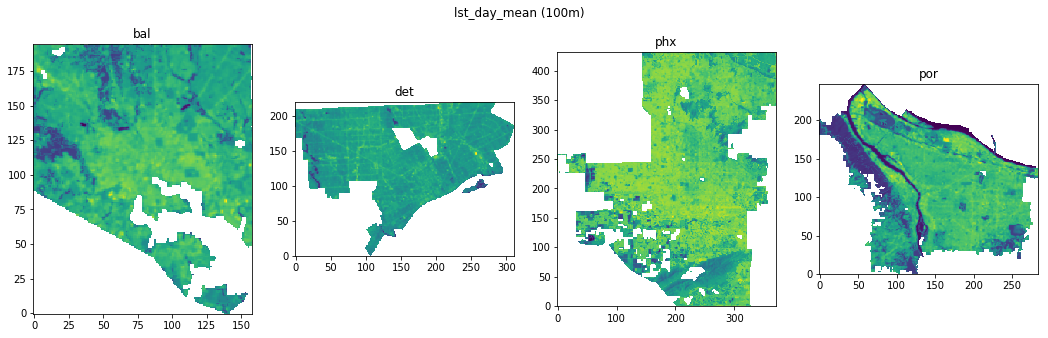

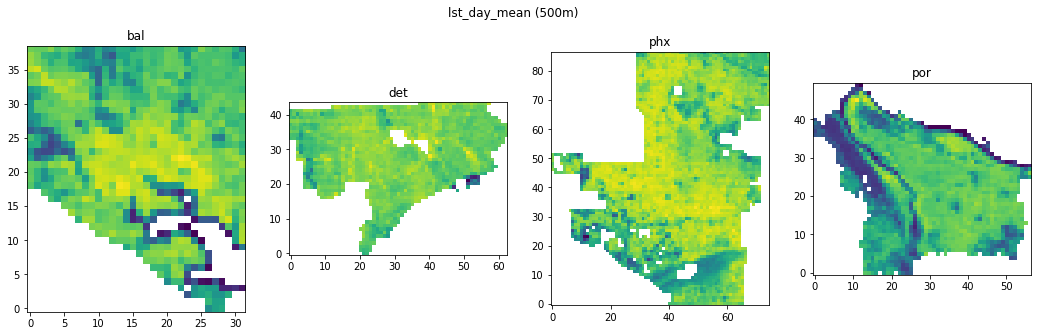

In [4]:
# Load data.
resolutions = [100, 500]
for resolution in resolutions:
    path = f'../../../data/data_vif_{resolution}.csv'
    df = pd.read_csv(path, index_col=0)
    
    # Check we can trust the index.
    assert df.index.is_monotonic_increasing
    assert df.index.is_unique

    # # Check there are no missing values.
    # assert df.isnull().values.sum() == 0

    # Remove spatial lag features.
    df = df.drop([c for c in df.columns if c.endswith('sl')], axis=1)

    # Not sure what this column is.
    df = df.drop('holdout', axis=1)

    # Specify the column order, to allow saving and loading as numpy arrays.
    # assert sorted(list(df.columns)) == sorted(IMAGE_GRID_CHANNELS + ['city'])

    # Temp change until data is sorted out.
    IMAGE_GRID_CHANNELS = [c for c in df.columns if c != 'city'] 
    
    # Reshape into a grid for each city.
    city_names = df.city.unique()
    city_names.sort()
    grids = []

    for city_name in city_names:
        df_city = df[df.city == city_name].copy()

        # Convert x-y coords to integer indices.
        df_city['x_index'] = (df_city.x - df_city.x.min()) / resolution
        df_city['y_index'] = (df_city.y - df_city.y.min()) / resolution
        df_city['x_index'] = df_city.x_index.round().astype(int)
        df_city['y_index'] = df_city.y_index.round().astype(int)

        # Make an empty grid.
        n_x = df_city.x_index.max() + 1
        n_y = df_city.y_index.max() + 1
        n_channels = len(IMAGE_GRID_CHANNELS)
        grid = np.full([n_y, n_x, n_channels], np.nan)

        # Fill grid.
        for row in df_city.itertuples():
            for i_channel, col in enumerate(IMAGE_GRID_CHANNELS):
                grid[row.y_index, row.x_index, i_channel] = getattr(row, col)
                
        # Save grid.
        np.save(f'../../../data/image-grid_{resolution}_{city_name}.npy', grid)
        grids.append(grid)
        
    # Visualise cities.
    fig, axes = plt.subplots(1, len(city_names), figsize=(18, 5))
    fig.suptitle(f'lst_day_mean ({resolution}m)')
    for ax, grid, city_name in zip(axes, grids, city_names):
        data = grid[:, :, IMAGE_GRID_CHANNELS.index('lst_day_mean')]
        # data = grid[:, :, 0]
        ax.imshow(data, origin='lower')
        ax.set_title(city_name)
        
    # Save the grid columns used as well.
    with open('../../../data/image-grid-channels_{}.p'.format(resolution), 'wb') as f:
        pickle.dump(IMAGE_GRID_CHANNELS, f)

In [5]:
df

,x,y,city,lst_day_mean,lst_night_mean,lst_day_max,lst_night_max,ndvi_mean,alb_mean,svf_mean,dsm_sd,bldg,lcov_11,tree_mean,svf_max,nbdi_max,tree_max,dsm_mean,pdens_mean,tree_min
0,4.249962e+05,189212.211496,bal,2.032633,-0.278660,0.560895,-1.287420,0.969374,-0.701644,-0.401105,-0.186424,0.797467,-0.195994,-0.489894,0.413039,-0.504623,-0.004023,1.420196,0.391065,-0.048624
1,4.254962e+05,189212.211496,bal,1.557503,-0.357349,-1.992316,-1.559181,1.355726,-0.771386,-0.362169,-0.348510,0.228484,-0.195994,-0.530055,0.462616,-1.029955,-0.004023,1.385107,1.224351,-0.048624
2,4.259962e+05,189212.211496,bal,1.608594,-0.440229,-0.247817,-2.130600,1.429002,-0.932881,-0.189718,-0.368851,0.231592,-0.195994,-0.552869,0.024234,-1.981745,0.039183,1.374027,1.554907,-0.048624
3,4.264962e+05,189212.211496,bal,2.973239,0.109484,0.233114,-1.358581,0.813393,-0.741008,-0.436824,-0.301456,0.574349,-0.195994,-0.504370,0.442564,-1.613264,-0.004023,1.346849,2.907206,-0.048624
4,4.269962e+05,189212.211496,bal,0.278084,-0.973977,-0.056063,-1.329702,1.152259,-0.535120,-0.404257,-0.248893,-0.014751,-0.195994,-0.284177,-0.066103,-1.579102,-0.004023,1.251960,2.336701,-0.048624
5,4.274962e+05,189212.211496,bal,1.443244,-0.516328,-1.030120,-1.864288,1.389183,-0.760479,-0.307268,-0.144059,0.173711,-0.195994,-0.470487,-0.065599,-1.091533,-0.004023,1.134174,0.866746,-0.048624
6,4.279962e+05,189212.211496,bal,0.639035,-1.383107,-1.995318,-2.263366,1.729904,-0.930131,-0.293462,-0.030005,-0.211068,-0.195994,-0.432326,-0.715893,-2.341707,-0.004023,1.021754,0.647667,-0.048624
7,4.284962e+05,189212.211496,bal,-1.892690,-2.524542,-0.372233,-0.107954,1.863131,-1.072109,-1.015895,0.151255,-0.122439,-0.195994,-0.192290,-0.333335,-2.415638,-0.004023,0.967348,-0.316764,-0.048624
8,4.289962e+05,189212.211496,bal,-6.811354,-4.883079,-2.957034,-2.374843,2.296487,-1.329039,-1.436956,0.404232,-0.658059,-0.195994,0.301685,0.095274,-1.420380,0.082388,0.910818,-0.324005,-0.048624
9,4.294962e+05,189212.211496,bal,-6.208099,-4.767571,-1.825137,-2.467035,2.101726,-1.307802,-1.495327,0.518806,-0.309992,-0.195994,0.302259,0.276502,-1.187271,0.471239,0.648355,-0.623168,-0.048624
